In [71]:
from transformers import BertModel, BertTokenizer
import torch
from typing import List, Any
from tqdm import tqdm
import pickle
from collections import Counter
import itertools

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
data_dir = '../data/mixed/'
train_file = 'train.raw.txt'
test_file = 'test.raw.txt'

with open(data_dir + train_file, 'r') as f:
    train_data = f.readlines()
with open(data_dir + test_file, 'r') as f:
    test_data = f.readlines()

In [7]:
for i in range(10):
    print(train_data[i][:-1])

casting director	70 50
and getting paid for it so let's get	40 67 68 68 68 41 67 41
ways that i connect with you guys is so	79 79 79 70 70 79 76 79 79
different varieties and if you don't	50 23 22 19 19 19
along with like twice a day coworking events on zoom	59 58 58 58 58 58 58 58 58 58
doing both	79 79
while investing in real estate the first	44 53 53 44 44 44 43
so if you're interested in learning	67 71 71 71 71 71
really makes a difference so with that	40 40 40 40 40 13 22
you don't want to rain just like peace	49 49 49 49 49 49 49 49


In [47]:
line = train_data[0][:-1]
words, gestures = line.split('\t')

tokens = tokenizer.tokenize(words)
print(tokens)
input_ids = torch.tensor([tokenizer.encode(tokens, add_special_tokens=False)])
print(input_ids)
embeddings = model(input_ids)[0]
print(embeddings.shape)

word_spans = [(0,1), (1,2)]
print(embeddings[0, word_spans[0][0]:word_spans[0][1], :].shape)
print(embeddings[0, word_spans[1][0]:word_spans[1][1], :].mean(dim=0).shape)

['casting', 'director']
tensor([[9179, 2472]])
torch.Size([1, 2, 768])
torch.Size([1, 768])
torch.Size([768])


In [19]:
# Check whether the lengths of words and gestures are the same for all lines
count = 0
nomatch_lines = []
for i, line in enumerate(train_data):
    line = line[:-1]
    words, gestures = line.split('\t')
    input_ids = torch.tensor([tokenizer.encode(words, add_special_tokens=False)])
    num_ids = input_ids.shape[1]
    if num_ids != len(gestures.split()):
        nomatch_lines.append(i)
        count += 1
        # print(line)
print(count, len(train_data))

5984 17739
and getting paid for it so let's get	40 67 68 68 68 41 67 41


In [25]:
print(train_data[nomatch_lines[0]][:-1])
words, gestures = train_data[nomatch_lines[0]][:-1].split('\t')
input_ids = tokenizer.encode(words, add_special_tokens=False)
print(input_ids)
print(type(input_ids))
print(gestures)

and getting paid for it so let's get	40 67 68 68 68 41 67 41
[1998, 2893, 3825, 2005, 2009, 2061, 2292, 1005, 1055, 2131]
<class 'list'>
40 67 68 68 68 41 67 41


In [31]:
# for lines where the lengths of words and gestures are not the same
# estimate the word spans for the corresponding gestures
# For example, for input_ids = [1998, 2893, 3825, 2005, 2009, 2061, 2292, 1005, 1055, 2131], whose length is 10
# the corresponding gestures are '40 67 68 68 68 41 67 41', whose length is 8,
# then the word span for the first gesture 40 is [0,1], where 0 is from round(10*(0/8))
# For the second gesture 67, the word span is [1,2], where 1 is from round(10*(1/8))
# For the third gesture 68, the word span is [2,4], where 2 is from round(10*(2/8)) and 4 is from round(10*(3/8))
# For the fourth gesture 68, the word span is [5,6], where 5 is from round(10*(3/8)) and 6 is from round(10*(5/8))
# For the fifth gesture 68, the word span is [7,8], where 7 is from round(10*(6/8)) and 8 is from round(10*(7/8))
# Gesture => Word span
# 40, [0,1] => 10*(0/7)=0, 0+1=1 => [0,1]
# 67, [1,2] => left = round(10*(1/8))=1, right = max(left+1, round(10*(2/8)))=2 => [1,2]
# 68, [2,3] => left = round(10*(2/8))=2, right = max(left+1, round(10*(3/8)))=4 => [2,4]
# 68, [3,4] => left = round(10*(3/8))=4, right = max(left+1, round(10*(4/8)))=5 => [4,5]
# 68, [4,5] => left = round(10*(4/8))=5, right = max(left+1, round(10*(5/8)))=6 => [5,6]
# 41, [5,6] => left = round(10*(5/8))=6, right = max(left+1, round(10*(6/8)))=8 => [6,8]
# 67, [6,7] => left = round(10*(6/8))=8, right = max(left+1, round(10*(7/8)))=9 => [8,9]
# 41, [7,8] => left = round(10*(7/8))=9, right = max(left+1, round(10*(8/8)))=10 => [9,10]

def get_word_spans(input_ids: List[Any], gestures: List[Any]):
    num_ids = len(input_ids)
    num_gestures = len(gestures)
    word_spans = []
    for i in range(num_gestures):
        left = round(num_ids * (i / num_gestures))
        right = max(left + 1, round(num_ids * ((i + 1) / num_gestures)))
        word_spans.append((left, right))
    return word_spans

In [32]:
# Test get_word_spans
input_ids = [1998, 2893, 3825, 2005, 2009, 2061, 2292, 1005, 1055, 2131]
gestures = '40 67 68 68 68 41 67 41'.split()
word_spans = get_word_spans(input_ids, gestures)
print(word_spans)

[(0, 1), (1, 2), (2, 4), (4, 5), (5, 6), (6, 8), (8, 9), (9, 10)]


In [49]:
model.eval()
gesture_embeds = {}
for data in tqdm(train_data):
    line = data[:-1]
    words, gestures = line.split('\t')
    input_ids = tokenizer.encode(words, add_special_tokens=False)
    gestures = gestures.split()
    word_spans = get_word_spans(input_ids, gestures)
    # get embeddings
    input_ids_pt = torch.tensor([input_ids])
    embeddings = model(input_ids_pt)[0]
    for i, gesture in enumerate(gestures):
        if gesture not in gesture_embeds:
            gesture_embeds[gesture] = []
        gesture_embeds[gesture].append(embeddings[0, word_spans[i][0]:word_spans[i][1], :].mean(dim=0))

100%|██████████| 17739/17739 [10:07<00:00, 29.22it/s]


In [61]:
print(len(gesture_embeds))
print(len(gesture_embeds['40']))
print(gesture_embeds['40'][0].shape)
print(list(gesture_embeds.keys()))

# max gesture token
gesture_token_int = list(map(int, gesture_embeds.keys()))
print('max gesture token:', max(gesture_token_int))
print('invalid gesture tokens:', set(gesture_token_int) - set(range(max(gesture_token_int) + 1)))

86
9032
torch.Size([768])
['71', '13', '70', '46', '63', '10', '81', '54', '60', '48', '5', '7', '31', '-59', '61', '3', '45', '-29', '12', '78', '36', '19', '56', '39', '76', '58', '17', '67', '2', '33', '53', '-119', '59', '62', '69', '64', '27', '14', '77', '68', '65', '50', '35', '-159', '11', '4', '75', '37', '-89', '25', '26', '72', '47', '80', '74', '38', '41', '44', '-179', '51', '79', '43', '23', '18', '22', '73', '0', '55', '24', '52', '32', '15', '42', '34', '20', '6', '1', '30', '49', '21', '-149', '-239', '40', '28', '16', '29']
max gesture token: 81
invalid gesture tokens: {-159, -29, -59, -89, -119, -149, -179, -239}


In [65]:
# Save the gesture embeddings
# with open('gesture_embeds.pkl', 'wb') as f:
#     pickle.dump(gesture_embeds, f)

# Read the gesture embeddings
with open('gesture_embeds.pkl', 'rb') as f:
    gesture_embeds = pickle.load(f)

In [63]:
# Count the frequency of each gesture in train_data
gesture_freq = Counter()
for data in tqdm(train_data):
    line = data[:-1]
    words, gestures = line.split('\t')
    gestures = gestures.split()
    for gesture in gestures:
        gesture_freq[gesture] += 1
print(gesture_freq.most_common(10))

100%|██████████| 17739/17739 [00:00<00:00, 648446.56it/s]

[('79', 23830), ('71', 11766), ('49', 11668), ('41', 9034), ('40', 9032), ('70', 7859), ('0', 7080), ('67', 5645), ('76', 4590), ('50', 4050)]


In [58]:
# t-SNE plot for gesture embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

In [83]:
# plot the t-SNE plot for some of the most frequent gestures
num_gestures = 3
max_samples = 1000
sampled_embeds = []
sampled_labels = []
for gesture, freq in gesture_freq.most_common(num_gestures):
    n_samples = min(max_samples, len(gesture_embeds[gesture]))
    sampled_embeds.append(np.array([t.detach().numpy() for t in gesture_embeds[gesture][:n_samples]]))
    sampled_labels.append([gesture] * n_samples)
sampled_embeds_merge = np.concatenate(sampled_embeds, axis=0)

colors = ['red', 'blue', 'green', 'yellow', 'black', 'purple', 'orange', 'pink', 'brown', 'gray']
sampled_colors = []
for i in range(num_gestures):
    sampled_colors += [colors[i]] * len(sampled_labels[i])

for i in range(num_gestures):
    print(sampled_embeds[i].shape)
print(len(sampled_labels))
print(len(sampled_colors))
print(sampled_embeds_merge.shape)

(1000, 768)
(1000, 768)
(1000, 768)
3
3000
(3000, 768)


In [84]:
tsne = TSNE(n_components=2, random_state=0)
gesture_embeds_2d = tsne.fit_transform(sampled_embeds_merge)
print(gesture_embeds_2d.shape)

x = gesture_embeds_2d[:, 0]
y = gesture_embeds_2d[:, 1]


(3000, 2)


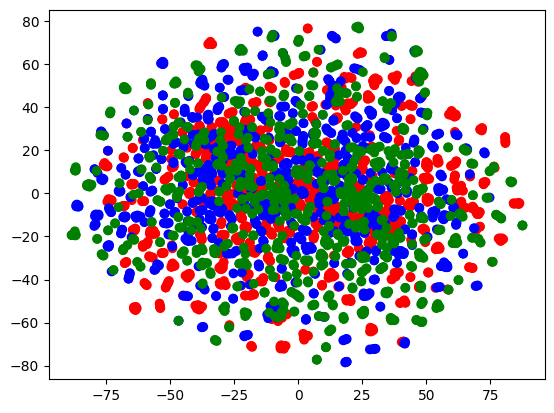

In [85]:
plt.scatter(x, y, c=sampled_colors)
plt.show()